# **Machine Learning Model**

This notebook implements a convolutional neural network to recognise different physical activities from Respeck sensor data. The dataset includes multiple 30-second recordings of various physical activities (e.g., ascending stairs, shuffle walking, sitting-standing) stored in separate CSV files for each activity.

This model will be deployed inside the Android app for live classification.


# Imports

In [1]:
# Importing libraries that will be used
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM, Attention
from tensorflow.keras.models import Model
from sklearn.utils import resample
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

# Reading Files
Reading files from your dataset

In [2]:
# Path to Respeck data
your_dataset_path = "./PDIoT2324/Respeck/"

This line uses the glob module to find all file paths that match a specified pattern. The 'glob.glob()' function returns a list of file paths that match the given pattern. `your_dataset_path` should be the directory where your dataset files are located.

The `*` is a wildcard character that matches any string of characters,  so this pattern retrieves all folders in the 'your_dataset_path' directory.

In [3]:
glob.glob(your_dataset_path + "*")

['./PDIoT2324/Respeck\\s100_respeck_ascending_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_descending_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_coughing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_hyperventilating.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_laughing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_singing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingBack_talking.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_coughing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_hyperventilating.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_laughing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_singing.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingLeft_talking.csv',
 './PDIoT2324/Respeck\\s100_respeck_lyingRight_breathingNormal.csv',
 './PDIoT2324/Respeck\\s100_respeck_

## Activities and Social Signals Dictionary

In [4]:
# Define activities and social signals with corresponding labels
# Each key is the name of the physical activity, and the corresponding value is the numeric label
# These labels will be used as the target variable for classification
activities_dict = {
    'ascending': 0,
    'shuffleWalking': 1,
    'sittingStanding': 2,
    'miscMovement': 3,
    'normalWalking': 4,
    'lyingBack': 5,
    'lyingLeft': 6,
    'lyingRight': 7,
    'lyingStomach': 8,
    'descending': 9,
    'running': 10
}

social_signals_dict = {
    'breathingNormal': 0,
    'coughing': 1,
    'hyperventilating': 2,
    'other': 3
}

# Functions

## Load list of files in an activity folder

In [5]:
def load_files_from_folder(folder_path):
    """
    Load all CSV files from a folder, extract activity and social signal information,
    and return a list of file paths along with combined labels and file information.

    Parameters:
    folder_path (str): The path to the folder containing CSV files.

    Returns:
    tuple: A tuple containing:
        - list: A list of file paths for all CSV files in the folder.
        - list: A list of combined labels (activity and social signal) for each file.
        - dict: A dictionary containing file information with activity and social signal labels.
    """

    # Initialise an empty list to store the full file paths of the CSV files
    file_paths = []

    # Initialise an empty dictionary to store the filenames and the activity and social signal labels
    file_info = {}

    # Initialise an empty list to store the combined labels of the activity and social signal to be used in stratified split of data
    # Stratified split of data ensures that each activity-social signal combination is proportionally represented in the training and testing data
    combined_labels = []

    # Loop through all the files in the given folder
    for file_name in os.listdir(folder_path):
        
        # Check if the file has a .csv extension (ignores other files)
        if file_name.endswith('.csv'):

            # Inialise an empty dictionary for each file to store the activity and social signal labels
            file_info[file_name] = {}

            # Split the file name by underscores to extract activity and social signal information
            parts = file_name.split("_")
            
            # Extract the activity from the file name
            activity = parts[2]

            # Add activity label to the file_info dictionary
            if activity == "sitting" or activity == "standing":
                file_info[file_name]['activity_label'] = activities_dict["sittingStanding"]
            else:
                file_info[file_name]['activity_label'] = activities_dict[activity]
            
            # Extract the social signal from the file name, without the .csv extension
            social_signal = parts[3].split(".")[0]

            # Add social signal label to the file_info dictionary
            if social_signal == "laughing" or social_signal == "eating" or social_signal == "talking" or social_signal == "singing":
                file_info[file_name]['social_signal_label'] = social_signals_dict["other"]
            else:
                file_info[file_name]['social_signal_label'] = social_signals_dict[social_signal]
            
            # Combine the activity and social signal to create a unique label
            combined_label = activity + "_" + social_signal

            # Append the combined label to the combined_labels list
            combined_labels.append(combined_label)

            # Construct the full file path by joining the folder path and the file name'
            full_file_path = os.path.join(folder_path, file_name)

            # Append the full file path to the file_paths list
            file_paths.append(full_file_path)

    # Return the complete list of CSV file paths
    return file_paths, combined_labels, file_info

## Train and test set split from list of files

In [6]:
def split_files(file_list, combined_labels, test_size=0.2):
    """
    Split the list of file paths into training and testing sets.

    Parameters:
    file_paths (list): A list of file paths for all CSV files.
    combined_labels (list): A list of combined labels (activity and social signal) for each file.
    test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.

    Returns:
    tuple: A tuple containing:
        - list: Training file paths.
        - list: Testing file paths.
    """

    # Split the file list into training and test sets using train_test_split from scikit-learn
    # test_size defines the proportion of the data to use as the test set (default is 20%)
    # shuffle=True ensures that the files are shuffled randomly before splitting
    # stratify is used to ensure that the proportion of each class is the same in both the training and testing sets
    # Separate files for each social signal class
    breathing_normal_files = [file for file, label in zip(file_list, combined_labels) if 'breathingNormal' in label]
    coughing_files = [file for file, label in zip(file_list, combined_labels) if 'coughing' in label]
    hyperventilating_files = [file for file, label in zip(file_list, combined_labels) if 'hyperventilating' in label]
    other_files = [file for file, label in zip(file_list, combined_labels) if 'laughing' in label or 'eating' in label or 'talking' in label or 'singing' in label]

    # Determine the target sample size for each class (e.g., the maximum class size to upsample to)
    target_samples = max(len(breathing_normal_files), len(coughing_files), len(hyperventilating_files), len(other_files))

    # Upsample each class to have the same number of samples
    breathing_normal_files = resample(breathing_normal_files, replace=True, n_samples=target_samples, random_state=42)
    coughing_files = resample(coughing_files, replace=True, n_samples=target_samples, random_state=42)
    hyperventilating_files = resample(hyperventilating_files, replace=True, n_samples=target_samples, random_state=42)
    other_files = resample(other_files, replace=True, n_samples=target_samples, random_state=42)

    # Combine the balanced samples
    balanced_files = breathing_normal_files + coughing_files + hyperventilating_files + other_files
    balanced_labels = (
    ['breathingNormal'] * len(breathing_normal_files) +
    ['coughing'] * len(coughing_files) +
    ['hyperventilating'] * len(hyperventilating_files) +
    ['other'] * len(other_files)
)

    # Now split with stratification
    train_files, test_files = train_test_split(
        balanced_files, test_size=test_size, stratify=balanced_labels, shuffle=True, random_state=42
    )

    # Return the train and test file lists
    return train_files, test_files


## Sliding Window

In time series Activity Recognition, a sliding window is a commonly used technique to segment continuous sensor data (such as accelerometer readings) into smaller, fixed-length overlapping or non-overlapping time intervals, or windows. Each window contains a sequence of sensor measurements that represent a short period of time, and this segmented data is used to extract features or make predictions about the activity happening within that window.

### Key Concepts of a Sliding Window
1.   **Window Size:** This refers to the length of each segment or window, typically defined in terms of the number of time steps or the duration (e.g., 2 seconds). The window size should be chosen carefully to capture enough information about the activity without making the window too large.
2.   **Step Size:** The step size determines how far the window moves forward after each step. If the step size is smaller than the window size, the windows will overlap. For example, if the window size is 5 seconds and the step size is 2 seconds, there will be a 3-second overlap between consecutive windows. Overlapping windows provide more data for analysis and can help smooth out predictions by capturing transitional activities.
3.   **Non-Overlapping Windows:** If the step size is equal to the window size, the windows do not overlap. This method provides distinct segments of data but may miss transitional phases between activities.

### Why Sliding Windows for Activity Recognition?

* Segmentation of Continuous Data: Activity recognition systems work with continuous streams of sensor data, and the sliding window helps segment these into manageable pieces to classify activities within specific intervals.

* Context Capturing: Human activities are often complex and spread across time. By using a sliding window, you can capture context across a short duration, which may include transitions or small fluctuations in the activity (e.g., a person moving from sitting to standing).

* Feature Extraction: Within each window, features such as mean, variance, frequency domain features, etc., can be extracted to help classify the activity.

* Real-Time Recognition: In real-time systems, the sliding window allows for continuous monitoring and updating of predictions as new data arrives.



In [7]:
def load_and_apply_sliding_windows(file_path, window_size, step_size, file_info):
    """
    Load the data from each file, apply sliding windows, and return the windows and labels.

    Parameters:
    file_paths (list): List of file paths to CSV files. Each file contains sensor data.
    window_size (int): The size of each sliding window (number of time steps).
    step_size (int): The step size (stride) between consecutive windows.
    file_info (dict): Dictionary containing file information with activity and social signal labels.

    Returns:
    tuple:
        - windows (numpy.ndarray): A 3D array of sliding windows, where each window has the shape
                                   (num_windows, window_size, num_features).
        - activity_labels (numpy.ndarray): A 1D array of activity labels, where each label corresponds to a sliding window.
        - social_signal_labels (numpy.ndarray): A 1D array of social signal labels, where each label corresponds to a sliding window.
    """
    # Initialise lists to store sliding windows and their corresponding labels
    windows = []
    activity_labels = []
    social_signal_labels = []
    file_number = 0

    
    # Loop through each file in the provided file path
    for file in file_path:

        # Extract the activity and social signal labels from the file_info dictionary
        activity_label = file_info[os.path.basename(file)]['activity_label']
        social_signal_label = file_info[os.path.basename(file)]['social_signal_label']

        # Load the CSV file into a pandas DataFrame
        data = pd.read_csv(file)   


        # Select the columns containing the necessary sensor data (acceleration readings)
        # These columns might vary depending on your dataset's structure
        data = data[['accel_x', 'accel_y', 'accel_z']]
        
        # Convert the DataFrame into a numpy array for faster processing in the sliding window operation
        data = data.to_numpy()

        
        # Get the number of samples (rows) and features (columns) in the data
        num_samples, num_features = data.shape
        
        # Apply sliding windows to the data
        # The range function defines the start of each window, moving step_size increments at a time
        for i in range(0, num_samples - window_size + 1, step_size):
            # Extract a window of size 'window_size' from the current position 'i'
            window = data[i:i + window_size, :]

            # Append the window to the windows list
            windows.append(window)

            # Assign the activity label to the window and append it to the activity labels list
            activity_labels.append(activity_label)

            # Assign the social signal label to the window and append it to the social signal labels list
            social_signal_labels.append(social_signal_label)

    # Convert the lists of windows and labels into numpy arrays for efficient numerical operations
    return np.array(windows), np.array(activity_labels), np.array(social_signal_labels) 

    
    

## Load and Split Train Test for Each Activity Folder

This function processes the sensor data for a specific activity, such as 'walking' or 'running', stored in its respective folder. It splits the data into training and testing sets, applies sliding windows, and labels the windows with the corresponding activity. This function can be used repeatedly for each activity to process and prepare data for training and evaluation.

In [8]:
def process_activity(dataset_path, window_size=100, step_size=50, test_size=0.2):
    """
    Processes an activity folder by loading the file list, splitting them into
    train and test sets, and applying sliding windows to the files.

    Args:
        dataset_path (str): Base path where the activity folders are located.
        window_size (int): Size of the sliding window, i.e., the number of time steps included in each window.
                           Default is 50.
        step_size (int): Step size for the sliding window, i.e., how far the window moves along the data.
                         Default is 20 (no overlap between windows).
        test_size (float): Proportion of files to use for testing. Default is 0.2, meaning 20% of files will
                           be allocated to the test set.

    Returns:
        tuple:
            - train_windows (numpy.ndarray): Sliding windows from the training files.
            - train_activity_labels (numpy.ndarray): Corresponding activity labels for the training windows.
            - train_social_signal_labels (numpy.ndarray): Corresponding social signal labels for the training windows.
            - test_windows (numpy.ndarray): Sliding windows from the test files.
            - test_activity_labels (numpy.ndarray): Corresponding activity labels for the test windows.
            - test_social_signal_labels (numpy.ndarray): Corresponding social signal labels for the test windows.
    """

    # Load all CSV file paths for the given activity from the folder
    file_paths, combined_labels, file_info = load_files_from_folder(dataset_path)

    # Split the file list into training and testing sets
    # train_files: files used for training
    # test_files: files used for testing
    train_files, test_files = split_files(file_paths, combined_labels, test_size=test_size)

    # Apply sliding windows to the training files
    # The function 'load_and_apply_sliding_windows' returns the sliding windows (segments) and their corresponding activity and social signal labels
    train_windows, train_activity_labels, train_social_signal_labels = load_and_apply_sliding_windows(train_files, window_size, step_size, file_info)

    # Apply sliding windows to the testing files
    test_windows, test_activity_labels, test_social_signal_labels = load_and_apply_sliding_windows(test_files, window_size, step_size, file_info)

    # Return the sliding windows and their labels for both training and testing sets
    return train_windows, train_activity_labels, train_social_signal_labels, test_windows, test_activity_labels, test_social_signal_labels

## 1D CNN Model

This function, `build_1d_cnn_model`, creates and compiles a 1D Convolutional Neural Network (CNN) for multi-label classification tasks.

### Function Overview

Input Parameters
* `input_shape`: Specifies the shape of the input data. It represents (timesteps, features), where timesteps refer to the length of the time series (e.g., 50 windows), and features represent the number of measurements in each time step (e.g., accelerometer readings).
* `num_activity_classes`: The number of output classes for the activity classification problem.
* `num_social_signal_classes`: The number of output classes for the social signal classification problem.

Returns
* The function returns a compiled 1D CNN model with two outputs that is ready to be trained on your data.

<hr>

### Function Breakdown
1. **Model Initialization:**
    * `inputs = Input(shape=input_shape)`: Initializes the input layer with the specified shape.
2. **First Convolutional Layer:**
    * `Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)`
        * This is the first 1D convolutional layer.
        * `filters=64`: The layer applies 64 filters (or kernels) over the input data.
        * `kernel_size=3`: Each filter will cover 3 timesteps at a time (a window of 3).
        * `activation='relu'`: The Rectified Linear Unit (ReLU) activation function introduces non-linearity and helps the model learn complex patterns.
    * `MaxPooling1D(pool_size=2)(x)`: This pooling layer reduces the dimensionality of the data by taking the maximum value from each 2-timestep window (`pool_size=2`).
3. **Second Convolutional Layer:**
    * `Conv1D(filters=128, kernel_size=3, activation='relu')(x)`
        * This is the second convolutional layer, similar to the first, but with 128 filters.
        * `kernel_size=3` and `activation='relu'` function in the same way as the first Conv1D layer.
    * `MaxPooling1D(pool_size=2)(x)`: Another pooling layer to downsample the output, further reducing the data’s dimensionality.
4. **Flattening Layer:**
    * `Flatten()(x)`: Converts the 2D output of the convolutional and pooling layers into a 1D vector.
5. **Fully Connected Layer:**
    * `Dense(128, activation='relu')(x)`: This is a fully connected layer with 128 units/neurons.
6. **Dropout Layer:**
    * `Dropout(0.5)(x)`: This layer randomly sets 50% of the neurons to zero during training to prevent overfitting.
7. **Output Layer for Activity Classification:**
    * `Dense(num_activity_classes, activation='softmax', name='activity_output')(x)`: This is the output layer for activity classification with `num_activity_classes` neurons.
8. **Output Layer for Social Signal Classification:**
    * `Dense(num_social_signal_classes, activation='softmax', name='social_signal_output')(x)`: This is the output layer for social signal classification with `num_social_signal_classes` neurons.
9. **Model Definition:**
    * `model = Model(inputs=inputs, outputs=[activity_output, social_signal_output])`: Defines the model with two outputs.
10. **Compiling the Model:**
    * `model.compile(optimizer='adam', loss={'activity_output': 'categorical_crossentropy', 'social_signal_output': 'categorical_crossentropy'}, metrics={'activity_output': 'accuracy', 'social_signal_output': 'accuracy'})`
        * Optimizer: 'adam': Adam is an optimization algorithm that adjusts the learning rate during training to improve performance.
        * Loss: 'categorical_crossentropy': This loss function is used for multi-class classification problems where the target variable is one-hot encoded.
        * Metrics: ['accuracy']: The accuracy metric is used to evaluate the model’s performance during training and testing.

In [9]:
def build_1d_cnn_model(input_shape, num_activity_classes, num_social_signal_classes):
    """
    Builds and compiles a 1D CNN model for multi-label classification.

    Args:
        input_shape (tuple): The shape of the input data (timesteps, features).
        num_activity_classes (int): The number of output activity classes.
        num_social_signal_classes (int): The number of output social signal classes.

    Returns:
        model (Sequential): Compiled 1D CNN model with two outputs.
    """
     # Input layer
    inputs = Input(shape=input_shape)

    # Shared Conv1D layer
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    # Separate Conv1D layers for activity and social signal
    activity_branch = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    social_signal_branch = Conv1D(filters=128, kernel_size=3, activation='relu')(x)

    # Add LSTM layer for social signal branch
    social_signal_branch = MaxPooling1D(pool_size=2)(social_signal_branch)
    social_signal_branch = LSTM(64, return_sequences=True)(social_signal_branch)

    # Add attention layer for social signal
    social_signal_branch = Attention()([social_signal_branch, social_signal_branch])

    # Pooling, flatten, and fully connected layers
    activity_branch = MaxPooling1D(pool_size=2)(activity_branch)
    activity_branch = Flatten()(activity_branch)
    activity_branch = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(activity_branch)
    activity_branch = Dropout(0.3)(activity_branch)
    activity_output = Dense(num_activity_classes, activation='softmax', name='activity_output')(activity_branch)

    social_signal_branch = Flatten()(social_signal_branch)
    social_signal_branch = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(social_signal_branch)
    social_signal_branch = Dropout(0.3)(social_signal_branch)
    social_signal_output = Dense(num_social_signal_classes, activation='softmax', name='social_signal_output')(social_signal_branch)

    # Define the model with two outputs
    model = Model(inputs=inputs, outputs=[activity_output, social_signal_output])

    # Compile the model with weighted loss
    model.compile(
        optimizer='adam',
        loss={
            'activity_output': 'categorical_crossentropy',
            'social_signal_output': 'categorical_crossentropy'
        },
        metrics={
            'activity_output': 'accuracy',
            'social_signal_output': 'accuracy'
        }
    )

    return model

# Classification Pipeline

## Step 1: Prepare and Preprocess the Data

Now the training and testing data will be created by calling the function `process_activity`. The `process_activity` function is used to generate sliding windows and labels for the training and testing sets.
* `X_train` and `X_test` are 3D arrays of sliding windows (shape: num_windows, window_size, num_features).
* `y_train_activity` and `y_train_social_signal` are 1D arrays of activity and social signal labels for the training set.
* `y_test_activity` and `y_test_social_signal` are 1D arrays of activity and social signal labels for the testing set.

In [10]:
# Generate the sliding windows along with activity and social signal labels for training and testing sets
X_train, y_train_activity, y_train_social_signal, X_test, y_test_activity, y_test_social_signal = process_activity(your_dataset_path, test_size=0.2, window_size=50, step_size=50)
print(f"{len(X_train)} train windows generated with {len(y_train_activity)} activity labels and {len(y_train_social_signal)} social signal labels")
print(f"{len(X_test)} test windows generated with {len(y_test_activity)} activity labels and {len(y_test_social_signal)} social signal labels")


88697 train windows generated with 88697 activity labels and 88697 social signal labels
22179 test windows generated with 22179 activity labels and 22179 social signal labels


Now the training and testing sets generated by the `process_activity` function are checked to see that they have the correct shape.

In [11]:
# Print the shapes of the training and test arrays to verify that everything has been combined correctly
print(f"X_train shape: {X_train.shape}, y_train_activity shape: {y_train_activity.shape}, y_train_social_signal shape: {y_train_social_signal.shape}")
print(f"X_test shape: {X_test.shape}, y_test_activity shape: {y_test_activity.shape}, y_test_social_signal shape: {y_test_social_signal.shape}")

X_train shape: (88697, 50, 3), y_train_activity shape: (88697,), y_train_social_signal shape: (88697,)
X_test shape: (22179, 50, 3), y_test_activity shape: (22179,), y_test_social_signal shape: (22179,)


### One-Hot Encode Labels (for multi-class classification)
Since there are more than two classes, the labels must be one-hot encoded, especially as the model will use categorical cross-entropy loss.

One-Hot Encoding converts categorical labels into binary vectors (one-hot encoded format). Each class label is represented as a binary vector with 1 for the correct class and 0 for others. This is necessary for training models that use categorical_crossentropy as the loss function, such as a neural network.

In [12]:
# Initialise the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit the OneHotEncoder on the training activity labels and transform them to one-hot encoded format
y_train_activity_one_hot = encoder.fit_transform(y_train_activity.reshape(-1, 1))

# Transform the test activity labels to one-hot encoded format using the already fitted encoder
y_test_activity_one_hot = encoder.transform(y_test_activity.reshape(-1, 1))


# Fit the OneHotEncoder on the training social signal labels and transform them to one-hot encoded format
y_train_social_signal_one_hot = encoder.fit_transform(y_train_social_signal.reshape(-1, 1))

# Transform the test social signal labels to one-hot encoded format using the already fitted encoder
y_test_social_signal_one_hot = encoder.transform(y_test_social_signal.reshape(-1, 1))

# Explanation:
# - y_train_activity_one_hot, y_train_social_signal_one_hot, y_test_activity_one_hot and y_test_social_signal_one_hot are now 2D arrays where each row is a one-hot encoded binary vector corresponding to a class label.
# - The number of columns in the one-hot encoded labels equals the number of unique classes (activities).
# For example, if there are 6 unique activities, the encoded vector will have 6 elements, with a '1' indicating the correct class.

In [13]:
# Print the shapes of the one-hot encoded labels to verify that the transformation was successful
print(f"y_train_activity_one_hot shape: {y_train_activity_one_hot.shape}, y_train_social_signal_one_hot shape: {y_train_social_signal_one_hot.shape}, y_test_activity_one_hot shape: {y_test_activity_one_hot.shape}, y_test_social_signal_one_hot shape: {y_test_social_signal_one_hot.shape}")

# Explanation of shapes:
# - The shape of y_train_activity_one_hot will be (num_samples, num_classes), where:
#     - num_samples is the number of training windows.
#     - num_classes is the number of unique activities (the length of the one-hot vectors).
# - Similarly, y_test_activity_one_hot will have the same number of columns (num_classes) as y_train_activity_one_hot but will have fewer rows (corresponding to the number of test windows).

y_train_activity_one_hot shape: (88697, 11), y_train_social_signal_one_hot shape: (88697, 4), y_test_activity_one_hot shape: (22179, 11), y_test_social_signal_one_hot shape: (22179, 4)


## Step 2: Build the 1D-CNN Model
Call our `build_1d_cnn_model` function to build our model

In [14]:
# Determine the input shape for the model
input_shape = (X_train.shape[1], X_train.shape[2])

# Determine the number of output classes (num_classes)
num_activity_classes = y_train_activity_one_hot.shape[1]
num_social_signal_classes = y_train_social_signal_one_hot.shape[1]

# Build and compile the model
# The function will return a compiled model ready for training
model = build_1d_cnn_model(input_shape, num_activity_classes, num_social_signal_classes)

## Step 3: Train and Evaluate the CNN Model

Train the 1D CNN model using the training data and validate on the test data. The model will learn to map input sliding windows to their corresponding activity and social signal labels.

`model.fit()` is used to train the neural network model. It takes several parameters:
* `X_train`: The input training data (sliding windows), with shape (num_samples, window_size, num_features).
* `{'activity_output': y_train_activity_one_hot, 'social_signal_output': y_train_social_signal_one_hot}`: The corresponding one-hot encoded labels for the training data, with shape (num_samples, num_classes).
* `epochs`: Number of times the entire training dataset is passed through the model. In this case, we are training for 20 epochs, meaning the model will see the entire training set 20 times.
* `batch_size`: Number of samples processed before the model's weights are updated. Here, the batch size is set to 32, meaning the model will process 32 samples at a time before updating its parameters.
* `validation_data`: This parameter allows us to evaluate the model's performance on the test data after each epoch. It takes the test data and corresponding one-hot encoded test labels.

After training, the model is evaluated on the test set. This is done with  5-Fold Cross-Validation.

`val_accuracy` is the accuracy of the model on the validation data (in this case X_test, y_test_activity_one_hot and y_test_social_signal_one_hot). The `accuracy` is the training accuracy for the current epoch.

In [15]:
# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialise lists to store the accuracy of each fold
activity_accuracy = []
social_signal_accuracy = []

# Initialise lists to store the true and predicted labels for social signals for all folds
# These lists will be used to create the confusion matrix for the social signal labels
all_y_true_social_signal = []
all_y_pred_social_signal = []

# Perform KFold cross-validation
fold_no = 1

for train_index, val_index in kfold.split(X_train):
    print(f"Training fold {fold_no}")

    # Split the data for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_activity_fold, y_val_activity_fold = y_train_activity_one_hot[train_index], y_train_activity_one_hot[val_index]
    y_train_social_signal_fold, y_val_social_signal_fold = y_train_social_signal_one_hot[train_index], y_train_social_signal_one_hot[val_index]


    # Build and compile the model
    model = build_1d_cnn_model(input_shape, num_activity_classes, num_social_signal_classes)

    # Train the model on this fold
    history = model.fit(
        X_train_fold,
        {'activity_output': y_train_activity_fold, 'social_signal_output': y_train_social_signal_fold},
        epochs=20,
        batch_size=32,
        validation_data=(X_val_fold, {'activity_output': y_val_activity_fold, 'social_signal_output': y_val_social_signal_fold}),
        verbose=0,  # Optional: Set to 0 for silent training
    )

    # Evaluate the model on the validation set
    y_pred_probs = model.predict(X_val_fold)
    y_pred_probs_activity = np.argmax(y_pred_probs[0], axis = 1)
    y_pred_probs_social_signal = np.argmax(y_pred_probs[1], axis = 1)

    y_true_activity = np.argmax(y_val_activity_fold, axis = 1)
    y_true_social_signal = np.argmax(y_val_social_signal_fold, axis = 1)

    # Generate the classification report for activity and social signal labels
    report_activity = classification_report(y_true_activity, y_pred_probs_activity, output_dict=True)
    report_social_signal = classification_report(y_true_social_signal, y_pred_probs_social_signal, output_dict=True)

    # Collect predictions and true social signal labels for confusion matrix
    all_y_true_social_signal.extend(y_true_social_signal)
    all_y_pred_social_signal.extend(y_pred_probs_social_signal)

    # Append the reports to the lists for averaging later
    activity_accuracy.append(report_activity['accuracy'])
    social_signal_accuracy.append(report_social_signal['accuracy'])

    print(f"Completed fold {fold_no}")
    fold_no += 1

average_activity_accuracy = np.mean(activity_accuracy)
average_social_signal_accuracy = np.mean(social_signal_accuracy)

# Convert the lists for the confusion matrix to numpy arrays
all_y_true_social_signal = np.array(all_y_true_social_signal)
all_y_pred_social_signal = np.array(all_y_pred_social_signal)

print(f"Average Activity Accuracy: {average_activity_accuracy:.4f}")
print(f"Average Social Signal Accuracy: {average_social_signal_accuracy:.4f}")


Training fold 1
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Completed fold 1
Training fold 2
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Completed fold 2
Training fold 3
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Completed fold 3
Training fold 4
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Completed fold 4
Training fold 5
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Completed fold 5
Average Activity Accuracy: 0.9751
Average Social Signal Accuracy: 0.8131


## Confusion Matrix

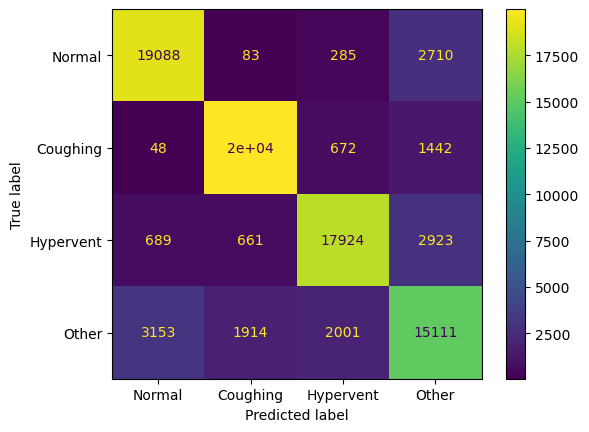

In [20]:
# Generate confusion matrix
cm = confusion_matrix(all_y_true_social_signal, all_y_pred_social_signal)
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Coughing', 'Hypervent', 'Other']).plot()

# Exporting your model to TFLite

You can use the TFLiteConverter class provided by TensorFlow to convert your trained model into the TensorFlow Lite format. We export models to TensorFlow Lite (TFLite) for several reasons, primarily because TFLite is designed for deployment on edge devices, such as mobile phones, embedded systems, IoT devices, and microcontrollers, where computational resources and power are limited. This is necessary as you will be running your ML models on your Android devices to perform live classification.

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully exported to model.tflite")


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpl4aqxetw\assets


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpl4aqxetw\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpl4aqxetw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name='keras_tensor_85')
Output Type:
  List[TensorSpec(shape=(None, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]
Captures:
  1927137419408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927119591120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927119598800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927119598032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927119592848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927119591312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927119586512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927119595536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927119585936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19272640452

## Testing the accuracy of the TFLite model

In [18]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Placeholder lists for storing predictions
activity_predictions = []
social_signal_predictions = []

# Run inference on each test sample
for i in range(len(X_test)):
    # Set the input tensor to the test sample
    input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensors
    activity_output = interpreter.get_tensor(output_details[0]['index'])
    social_signal_output = interpreter.get_tensor(output_details[1]['index'])

    # Convert output to class predictions
    activity_pred = np.argmax(activity_output, axis=1)[0]
    social_signal_pred = np.argmax(social_signal_output, axis=1)[0]


    # Append the predictions to the output lists
    activity_predictions.append(activity_pred)
    social_signal_predictions.append(social_signal_pred)

    # Convert one-hot encoded labels to class labels
    y_true_activity = np.argmax(y_test_activity_one_hot, axis=1)
    y_true_social_signal = np.argmax(y_test_social_signal_one_hot, axis=1)

    # Calculate accuracy
    activity_accuracy = accuracy_score(y_true_activity, activity_predictions)
    social_signal_accuracy = accuracy_score(y_true_social_signal, social_signal_predictions)

    # Print accuracy
    print(f"Activity Accuracy: {activity_accuracy:.4f}")
    print(f"Social Signal Accuracy: {social_signal_accuracy:.4f}")

    # Generate and print classification reports
    report_activity = classification_report(y_true_activity, activity_predictions, output_dict=True)
    report_social_signal = classification_report(y_true_social_signal, social_signal_predictions, output_dict=True)


ValueError: Found input variables with inconsistent numbers of samples: [22179, 1]